In [1]:
from unityagents import UnityEnvironment
from collections import deque

import numpy as np
import progressbar as pb

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
env = UnityEnvironment(file_name="./Crawler_Windows_x86_64/Crawler.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: CrawlerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 129
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 20
        Vector Action descriptions: , , , , , , , , , , , , , , , , , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 12
Size of each action: 20
There are 12 agents. Each observes a state with length: 129
The state for the first agent looks like: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.25000000e+00
  1.00000000e+00  0.00000000e+00  1.78813934e-07  0.00000000e+00
  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  6.06093168e-01 -1.42857209e-01 -6.06078804e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.33339906e+00 -1.42857209e-01
 -1.33341408e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.0609

In [5]:
def interact(action):
    action = action.reshape(num_agents, action_size)
    env_info = env.step(action)[brain_name]
    next_state, reward, done = env_info.vector_observations, env_info.rewards, env_info.local_done
    return next_state.reshape(num_agents, -1), np.array(reward).reshape(num_agents, -1), np.array(done).reshape(num_agents, -1)

def reset():
    state = env.reset()[brain_name].vector_observations.reshape(num_agents, -1)
    return state

In [6]:
NET_SIZE = 512

class Policy(nn.Module):
    
    def __init__(self, state_size, action_size=1, n_agents=1, fc1_size=NET_SIZE, fc2_size=NET_SIZE):
        super(Policy, self).__init__()
        
        self.bn0 = nn.BatchNorm1d(state_size)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.bn1 = nn.BatchNorm1d(fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.bn2 = nn.BatchNorm1d(fc1_size)
        self.fc3_mu = nn.Linear(fc2_size, action_size)
        self.fc3_std = nn.Linear(fc2_size, action_size)

    def forward(self, state, log_std_min=-20, log_std_max=2):
        x = self.bn0(state)
        x = torch.relu(self.bn1(self.fc1(state)))
        x = torch.relu(self.bn2(self.fc2(x)))

        mean = self.fc3_mu(x)
        std = self.fc3_std(x)
        std = torch.clamp(std, log_std_min, log_std_max).exp()

        return mean, std
    
class Value(nn.Module):
    
    def __init__(self, state_size, action_size=1, n_agents=1, fc1_size=NET_SIZE, fc2_size=NET_SIZE):
        
        super(Value, self).__init__()
        
        self.bn0 = nn.BatchNorm1d(state_size)
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, 1)
        
    def forward(self, x):
        x = self.bn0(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
    
class Q(nn.Module):
    
    def __init__(self, state_size, action_size, n_agents=1, fc1_size=NET_SIZE, fc2_size=NET_SIZE):
        
        super(Q, self).__init__()
        
        self.bn0 = nn.BatchNorm1d(state_size+action_size)
        self.fc1 = nn.Linear(state_size + action_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, 1)
        
    def forward(self, s, a):
        x = torch.cat([s, a], 1)
        x = self.bn0(x)
        x = torch.relu(self.fc1(x)) 
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
from algorithms.sac import Agent

agent = Agent(
    state_size=state_size, 
    action_size=action_size,
    policy_network=Policy,
    value_network=Value,
    q_network=Q,
    n_agents=num_agents, 
    device=device,
)

D:\Anaconda\envs\gym\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\envs\gym\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\envs\gym\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\envs\gym\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: FutureWa

In [8]:
# agent.policy_network.load_state_dict(torch.load("./trained_models/sac-reacher/POLICY.pth"))
# agent.value_network_local.load_state_dict(torch.load("./trained_models/sac-reacher/VALUE_LOCAL.pth"))
# agent.value_network_target.load_state_dict(torch.load("./trained_models/sac-reacher/VALUE_LOCAL.pth"))
# agent.q_network_1.load_state_dict(torch.load("./trained_models/sac-reacher/Q_1.pth"))
# agent.q_network_2.load_state_dict(torch.load("./trained_models/sac-reacher/Q_2.pth"))

In [9]:
def run(n_episodes, t_max, print_every):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=print_every)  # last 100 scores
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA()]
    timer = pb.ProgressBar(widgets=widget, maxval=n_episodes).start()
    
    frame_counter = 0
    
    for i_episode in range(1, n_episodes+1):
        states = reset()
        score = 0
        for t in range(t_max):
            frame_counter += 1
            actions = agent.act(states)
            next_states, rewards, dones = interact(actions)
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards.mean()
            if np.any(dones):
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        agent.writer.add_scalar('score/mean', score, i_episode)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tScore Mean: {:.2f}\tScore STD: {:.2f}'.format(i_episode, np.mean(scores_window), np.std(scores_window)))
        
        if np.mean(scores_window) > 30:
            break
            
        timer.update(i_episode)
    return scores

In [10]:
%time scores = run(t_max=int(10000), n_episodes=int(10000), print_every=100)

training loop:   0% |                                          | ETA:   1:28:00

Episode 100	Score Mean: 1.13	Score STD: 1.01


training loop:   1% |                                          | ETA:   1:24:30

Episode 200	Score Mean: 1.49	Score STD: 1.95


training loop:   2% |#                                         | ETA:   1:46:44

Episode 300	Score Mean: 8.21	Score STD: 3.76


training loop:   3% |#                                         | ETA:   2:05:22

Episode 400	Score Mean: 12.20	Score STD: 2.82


training loop:   4% |##                                        | ETA:   2:17:01

Episode 500	Score Mean: 14.71	Score STD: 3.31


training loop:   5% |##                                        | ETA:   2:28:22

Episode 600	Score Mean: 18.42	Score STD: 3.29


training loop:   6% |##                                        | ETA:   2:43:59

Episode 700	Score Mean: 20.65	Score STD: 5.38


training loop:   7% |###                                       | ETA:   2:52:01

Episode 800	Score Mean: 21.39	Score STD: 4.56


training loop:   8% |###                                       | ETA:   2:57:03

Episode 900	Score Mean: 20.65	Score STD: 2.37


training loop:   9% |####                                      | ETA:   3:01:42

Episode 1000	Score Mean: 22.03	Score STD: 6.00


training loop:  10% |####                                      | ETA:   3:06:54

Episode 1100	Score Mean: 26.11	Score STD: 6.76


training loop:  11% |#####                                     | ETA:   3:10:59

Episode 1200	Score Mean: 26.74	Score STD: 6.09


training loop:  12% |#####                                     | ETA:   3:14:32

Episode 1300	Score Mean: 26.46	Score STD: 6.27


training loop:  13% |#####                                     | ETA:   3:18:55

Episode 1400	Score Mean: 28.71	Score STD: 7.11


training loop:  14% |######                                    | ETA:   3:20:33

Wall time: 33min 33s


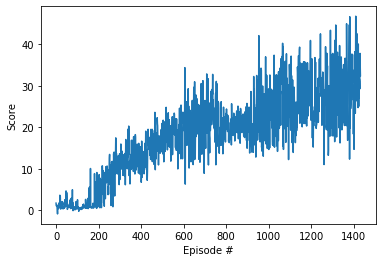

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [12]:
torch.save(agent.policy_network.state_dict(), "./trained_models/sac-crawler/POLICY.pth")
torch.save(agent.value_network_target.state_dict(), "./trained_models/sac-crawler/VALUE_TARGET.pth")
torch.save(agent.q_network_1.state_dict(), "./trained_models/sac-crawler/Q_1.pth")
torch.save(agent.q_network_2.state_dict(), "./trained_models/sac-crawler/Q_2.pth")

In [13]:
env.close()